<a href="https://colab.research.google.com/github/ynuozhang/mutant_specific/blob/master/GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount to Drive, Installs
from google.colab import drive
drive.mount('/content/drive')


!pip install pytorch
!pip install fair-esm
!pip install fuzzywuzzy
!pip install umap-learn

import numpy as np
import pandas as pd

import torch
import esm
from fuzzywuzzy import fuzz
import umap

import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.model_selection import train_test_split

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: Could not build wheels for pytorch, which is required to install pyproject.toml-based projects


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
#@title def add_scaled_columns(dataframe, col1, col2, boundary=10000)
def add_scaled_columns(dataframe, col1, col2, boundary=10000):
    # Extract the two columns
    sub_df = dataframe[[col1, col2]].copy()

    # Create a combined series for calculating scaling factor
    combined = sub_df[col1].append(sub_df[col2])

    # 1. Handle NaNs
    combined_filled = combined.fillna(1e9)

    # 2. Determine Scaling Factor
    # Find the maximum value excluding the NaN placeholders
    max_val = combined_filled[combined_filled != 1e9].max()

    # Compute the scaling factor so the max_val is just below 10000
    scaling_factor = (boundary - 1) / max_val

    # 3. Normalize Data
    # Scale the two columns and add them to the original dataframe
    dataframe[f"scaled_{col1}"] = sub_df[col1].mul(scaling_factor).fillna(boundary)
    dataframe[f"scaled_{col2}"] = sub_df[col2].mul(scaling_factor).fillna(boundary)
    return dataframe

In [ ]:
#@title prep data -- this is my wild type

df = pd.read_hdf('/content/drive/MyDrive/Ashley/Mutant_Specificity/reduced_proteins_embeddings_meta.hdf', key='df')
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['wild_seq_2_embeddings']], axis=1)
df['wt1_wt2_concat'] = df.apply(concatenate_vectors, axis=1)
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors_mut(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['mutant_seq_embeddings']], axis=1)
df['wt1_mut_concat'] = df.apply(concatenate_vectors_mut, axis=1)
df

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat
0,1CSE_E_I,LI45G,5.260000e-11,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
1,1CSE_E_I,LI45S,8.330000e-12,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
2,1CSE_E_I,LI45P,1.020000e-07,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
3,1CSE_E_I,LI45I,1.720000e-10,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
4,1CSE_E_I,LI45D,1.920000e-09,1.120000e-12,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,7.410000e-05,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2022,2WPT_A_B,"DA33A,FB86A",6.210000e-07,8.200000e-07,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520..."
2023,2WPT_A_B,NA34A,6.490000e-07,8.200000e-07,Colicin E9 DNase,Colicin E2 immunity protein,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MELKHSISDYTEAEFLEFVKKIARAEG

In [ ]:
#@title Normalize affinity data
df['Affinity_mut_parsed'] = df['Affinity_mut_parsed'] * (10 ** 9)
df['Affinity_wt_parsed'] = df['Affinity_wt_parsed'] * (10 ** 9)
df = add_scaled_columns(df, 'Affinity_mut_parsed', 'Affinity_wt_parsed')
df

<ipython-input-2-58d8430129fc>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = sub_df[col1].append(sub_df[col2])


,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat,scaled_Affinity_mut_parsed,scaled_Affinity_wt_parsed
0,1CSE_E_I,LI45G,0.05260,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.000104,0.000002
1,1CSE_E_I,LI45S,0.00833,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...,-2.006535,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.0537039, -0.024117924, 0.027800042, -0.046...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.000016,0.000002
2,1CSE_E_I,LI45P,102.00000,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...,-11.419399,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.05011466, -0.026969189, 0.025009282, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.200767,0.000002
3,1CSE_E_I,LI45I,0.17200,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...,-5.034166,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.053000774, -0.027996115, 0.027281117, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.000339,0.000002
4,1CSE_E_I,LI45D,1.92000,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...,-7.446752,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.052454446, -0.025797503, 0.02369322, -0.05...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.003779,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,2WPT_A_B,FB86A,74100.00000,820.00000,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,-4.503866,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...",145.851555,1.614012
2022,2WPT_A_B,"DA33A,FB86A",621.00000,820.00000,Colicin E2 immunity protein,Colicin E9 DNase,MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...,0.277973,"[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[-0.023957022, -0.03359121, -0.03746649, 0.00...","[[-0.02314554, -0.030065024, -0.04236627, 0.00...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...","[[0.042925045, 0.06613858, 0.017256295, 0.0520...",1.222319,1.614012
2023,2WPT_A_B,NA34A,649.00000,820.00000,Colicin E9 DNase,Colicin E2 immunity protein,ME

In [ ]:
#@title get max molar (found to be 1000.0)
max_molar = df[['scaled_Affinity_mut_parsed', 'scaled_Affinity_wt_parsed']].max().max()
max_molar

10000.0

In [ ]:
#@title construct wt training set, remove the duplicated wt1-wt2 entries
dt = df.copy()
dt.drop_duplicates(subset=['wild_seq_1', 'wild_seq_2'], inplace=True)
dt

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat,scaled_Affinity_mut_parsed,scaled_Affinity_wt_parsed
0,1CSE_E_I,LI45G,0.0526,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.000104,0.000002
6,1ACB_E_I,LI45G,45.5000,0.00149,Bovine alpha-chymotrypsin,Eglin c,CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...,-10.326691,"[[-0.02408382, -0.07500525, 0.095739715, 0.091...","[[0.055853, -0.026456483, 0.03352555, -0.05577...","[[0.0517656, -0.022764446, 0.028771894, -0.046...","[[-0.02408382, -0.07500525, 0.095739715, 0.091...","[[-0.02408382, -0.07500525, 0.095739715, 0.091...",0.089558,0.000003
12,1SBN_E_I,RI45K,0.0320,0.05400,Subtilisin BPN,Eglin c,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...,0.523248,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[0.045640845, -0.022037255, 0.03265124, -0.05...","[[0.043771047, -0.02445446, 0.027336929, -0.05...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...",0.000063,0.000106
13,1SIB_E_I,KI53R,0.0320,0.11000,Subtilisin BPN,Eglin c,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,1.234744,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[0.049512647, -0.024531225, 0.041538414, -0.0...","[[0.05586468, -0.02661387, 0.033568867, -0.055...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...",0.000063,0.000217
14,1Y1K_E_I,AI58T,0.0030,0.30000,Subtilisin BPN,Chymotrypsin inhibitor 2,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...,4.605170,"[[-0.02423378, -0.12586969, -0.016004924, 0.14...","[[0.022477234, -0.055314906, 0.017077997, -0.0...","[[0.018416919, -0.06049833, 0.017454382, -0.04...","[[-0.02423378, -0.12586969, -0.016004924, 0.14...","[[-0.02423378, -0.12586969, -0.016004924, 0.14...",0.000006,0.000590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,5UFE_A_B,QB27R,82.4000,50.30000,K-Ras,R11.1.6,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...,ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...,-0.493580,"[[0.033050254, -0.0015785629, -0.1265147, -0.0...","[[0.05051038, 0.027671836, -0.011607888, 0.014...","[[0.057605665, -0.03982812, -0.07390956, -0.09...","[[0.033050254, -0.0015785629, -0.1265147, -0.0...","[[0.033050254, -0.0015785629, -0.1265147, -0.0...",0.162189,0.099006
2012,5UFQ_A_C,"DA12G,QC27R,KC59G",82.4000,6.40000,K-Ras,R11.1.6,MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...,ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...,-2.555287,"[[0.03184991, 0.003854431, -0.122885644, -0.02...","[[0.05051038, 0.027671836, -0.011607888, 0.014...","[[0.06724904, -0.04644814, -0.072430626, -0.10...","[[0.03184991, 0.003854431, -0.122885644, -0.02...","[[0.03184991, 0.003854431, -0.122885644, -0.02...",0.162189,0.012597
2014,5TAR_A_B,"TA183A,KA184E",231000.0000,2300.00000,PDE delta,K-Ras,AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...,GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTI

In [ ]:
#@title train.test dataset split for wildtype ppis -- SHOULD MODIFY TO CROSS-VALIDATION LATER
train_wt, test_wt = train_test_split(dt[['wt1_wt2_concat', 'scaled_Affinity_wt_parsed']], test_size=0.2, random_state=42)
x_train_wt_array = np.vstack(train_wt['wt1_wt2_concat'].to_numpy())
y_train_wt_array = np.vstack(train_wt['scaled_Affinity_wt_parsed'].to_numpy())
x_test_wt_array = np.vstack(test_wt['wt1_wt2_concat'].to_numpy())
y_test_wt_array = np.vstack(test_wt['scaled_Affinity_wt_parsed'].to_numpy())

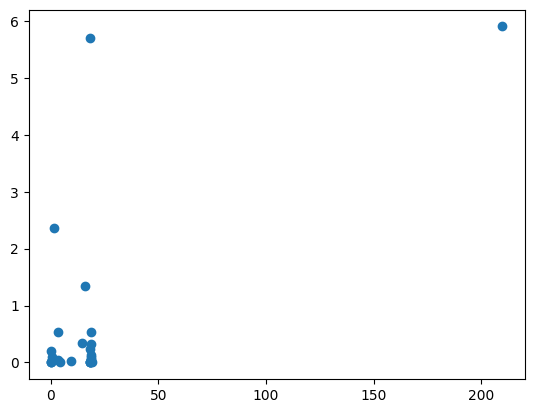

In [ ]:
#@title check GP model fit
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
n_samples, n_features = x_train_wt_array.shape
model = gpr.fit(x_train_wt_array, y_train_wt_array)
y_pred_wt, y_var_wt = gpr.predict(x_test_wt_array, return_std=True)
plt.figure()
plt.scatter(y_pred_wt, y_test_wt_array)
plt.show()

In [ ]:
#@title calc spearman corr
import scipy.stats as ss
ss.spearmanr(y_pred_wt, y_test_wt_array)

SignificanceResult(statistic=0.1487433771098107, pvalue=0.46833337540323816)

In [ ]:
#@title calc pearson corr -- um didn't work but yinuo said it was ok...
'''ss.pearsonr(y_pred_wt, y_test_wt_array)'''

'ss.pearsonr(y_pred_wt, y_test_wt_array)'

# GP

In [ ]:
from scipy.stats import rankdata
def acquisition_rank(y_pred, var_pred, beta=1.):
  print(y_pred.shape, var_pred.shape)
  return rankdata(y_pred, method='ordinal') + (beta * rankdata(var_pred))

In [ ]:
acquisition = acquisition_rank(y_pred_wt, y_var_wt)
acquisition

(26,) (26,)


array([22., 12., 30., 36., 43., 47.,  3., 50., 36., 37., 30.,  9., 35.,
       14., 35., 47., 30.,  9.,  6., 43.,  3., 16., 26., 40., 19., 24.])

In [ ]:
dt_train = df.copy()
dt_train.drop_duplicates(subset=['wild_seq_1', 'wild_seq_2'], inplace=True)
x_train_wt_array = np.vstack(dt_train['wt1_wt2_concat'].to_numpy())
y_train_wt_array = np.vstack(dt_train['scaled_Affinity_wt_parsed'].to_numpy())
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr=GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
model=gpr.fit(x_train_wt_array, y_train_wt_array)
dt_train

,#Pdb,Mutation(s)_PDB,Affinity_mut_parsed,Affinity_wt_parsed,Protein_1,Protein_2,wild_seq_1,wild_seq_2,mutant_seq,specificity_score,wild_seq_1_embeddings,wild_seq_2_embeddings,mutant_seq_embeddings,wt1_wt2_concat,wt1_mut_concat,scaled_Affinity_mut_parsed,scaled_Affinity_wt_parsed
0,1CSE_E_I,LI45G,0.0526,0.00112,Subtilisin Carlsberg,Eglin c,AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...,-3.849387,"[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[0.05527322, -0.029942056, 0.032425687, -0.05...","[[0.050374627, -0.026959267, 0.027378589, -0.0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...","[[-0.032166936, -0.15676358, -0.00066792156, 0...",0.000104,0.000002
6,1ACB_E_I,LI45G,45.5000,0.00149,Bovine alpha-chymotrypsin,Eglin c,CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...,-10.326691,"[[-0.02408382, -0.07500525, 0.095739715, 0.091...","[[0.055853, -0.026456483, 0.03352555, -0.05577...","[[0.0517656, -0.022764446, 0.028771894, -0.046...","[[-0.02408382, -0.07500525, 0.095739715, 0.091...","[[-0.02408382, -0.07500525, 0.095739715, 0.091...",0.089558,0.000003
12,1SBN_E_I,RI45K,0.0320,0.05400,Subtilisin BPN,Eglin c,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...,0.523248,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[0.045640845, -0.022037255, 0.03265124, -0.05...","[[0.043771047, -0.02445446, 0.027336929, -0.05...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...",0.000063,0.000106
13,1SIB_E_I,KI53R,0.0320,0.11000,Subtilisin BPN,Eglin c,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...,1.234744,"[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[0.049512647, -0.024531225, 0.041538414, -0.0...","[[0.05586468, -0.02661387, 0.033568867, -0.055...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...","[[-0.026620023, -0.12713915, -0.023718221, 0.1...",0.000063,0.000217
14,1Y1K_E_I,AI58T,0.0030,0.30000,Subtilisin BPN,Chymotrypsin inhibitor 2,AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...,MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...,4.605170,"[[-0.02423378, -0.12586969, -0.016004924, 0.14...","[[0.022477234, -0.055314906, 0.017077997, -0.0...","[[0.018416919, -0.06049833, 0.017454382, -0.04...","[[-0.02423378, -0.12586969, -0.016004924, 0.14...","[[-0.02423378, -0.12586969, -0.016004924, 0.14...",0.000006,0.000590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,5UFE_A_B,QB27R,82.4000,50.30000,K-Ras,R11.1.6,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...,ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...,-0.493580,"[[0.033050254, -0.0015785629, -0.1265147, -0.0...","[[0.05051038, 0.027671836, -0.011607888, 0.014...","[[0.057605665, -0.03982812, -0.07390956, -0.09...","[[0.033050254, -0.0015785629, -0.1265147, -0.0...","[[0.033050254, -0.0015785629, -0.1265147, -0.0...",0.162189,0.099006
2012,5UFQ_A_C,"DA12G,QC27R,KC59G",82.4000,6.40000,K-Ras,R11.1.6,MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...,ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...,ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...,-2.555287,"[[0.03184991, 0.003854431, -0.122885644, -0.02...","[[0.05051038, 0.027671836, -0.011607888, 0.014...","[[0.06724904, -0.04644814, -0.072430626, -0.10...","[[0.03184991, 0.003854431, -0.122885644, -0.02...","[[0.03184991, 0.003854431, -0.122885644, -0.02...",0.162189,0.012597
2014,5TAR_A_B,"TA183A,KA184E",231000.0000,2300.00000,PDE delta,K-Ras,AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...,GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTI

# Retrain GP
So now I have a GP trained with the entire skempi WT pairs (127), now fit it with the natural random sequences instead of the previous 20% of the WT pairs.

In [ ]:
#@title load in pickle file of natural random sequences
!pip install biopython
from google.colab import drive
drive.mount('/content/drive')
import Bio
import pickle

with open("/content/drive/MyDrive/Ashley/Mutant_Specificity/full_fake_embeddings.pk", "rb") as f:
  naturalpickle = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.DataFrame(list(naturalpickle.items()), columns=["Sequence", "Embeddings"])

# Display the first few rows
print(df.head())

# Flattening the arrays and creating a DataFrame
flattened_data = {seq: arr.flatten() for seq, arr in naturalpickle.items()}
df_flattened = pd.DataFrame.from_dict(flattened_data, orient='index')

# If you want the sequence as a separate column and not an index:
df_flattened.reset_index(inplace=True)
df_flattened.rename(columns={"index": "Sequence"}, inplace=True)

# Display the first few rows
print(df_flattened.head())


                                     Sequence  \
0     (M, Y, A, A, L, K, C, V, A, D, L, H, D)   
1     (M, N, N, T, L, E, L, Q, G, H, R, E, R)   
2     (M, R, P, G, R, T, S, E, G, A, C, E, D)   
3  (A, V, W, L, V, L, V, V, L, M, R, A, Q, L)   
4  (M, N, I, P, K, L, F, S, V, L, Y, L, G, C)   

                                          Embeddings  
0  [[-0.004631999, -0.007299112, 0.22264148, 0.03...  
1  [[-0.03607322, -0.029325524, 0.273595, -0.0670...  
2  [[-0.011407809, -0.03639245, 0.33202693, -0.01...  
3  [[0.00069177995, 0.113469884, 0.0017280156, 0....  
4  [[0.060281537, -0.05066143, 0.36259368, 0.0336...  
